In [1]:
import os
import zipfile
import pandas as pd

# Module constants
DATASET_DIR = os.path.join(os.getcwd(), 'datasets')
TRAINING_CSV =  os.path.join(DATASET_DIR, 'train.csv')
TEST_CSV = os.path.join(DATASET_DIR, 'test.csv')
DATA_ZIP = os.path.join(DATASET_DIR, 'all.zip')

In [2]:
# get dataset if flat file not readily available
def get_csv_from_zip(train_set=True):
    csv = TRAINING_CSV if train_set else TEST_CSV

    with zipfile.ZipFile(DATA_ZIP) as data_zip:
        member = 'train.csv' if train_set else 'test.csv'
        data_zip.extract(member, path=DATASET_DIR)

In [3]:
# load data via pandas
def load_dataset(csv=TRAINING_CSV):
    if not os.path.isfile(csv):
        get_csv_from_zip()

    return pd.read_csv(csv)

In [4]:
# Explore the data
train_set = load_dataset()
train_set.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB


In [5]:
# Name, Sex, Ticket, Cabin, and Embarked are non-numeric features
# Additinally, cabin, age, and embarked have incomplete data for some passangers
# Note - Name, Ticket, and Cabin seem irrelevant 

categorical_feat = list(train_set.select_dtypes(include='object').columns)
print(train_set['Sex'].value_counts())
print()
print(train_set['Embarked'].value_counts())

male      577
female    314
Name: Sex, dtype: int64

S    644
C    168
Q     77
Name: Embarked, dtype: int64


In [6]:
# Get summary of numerical features
train_set.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


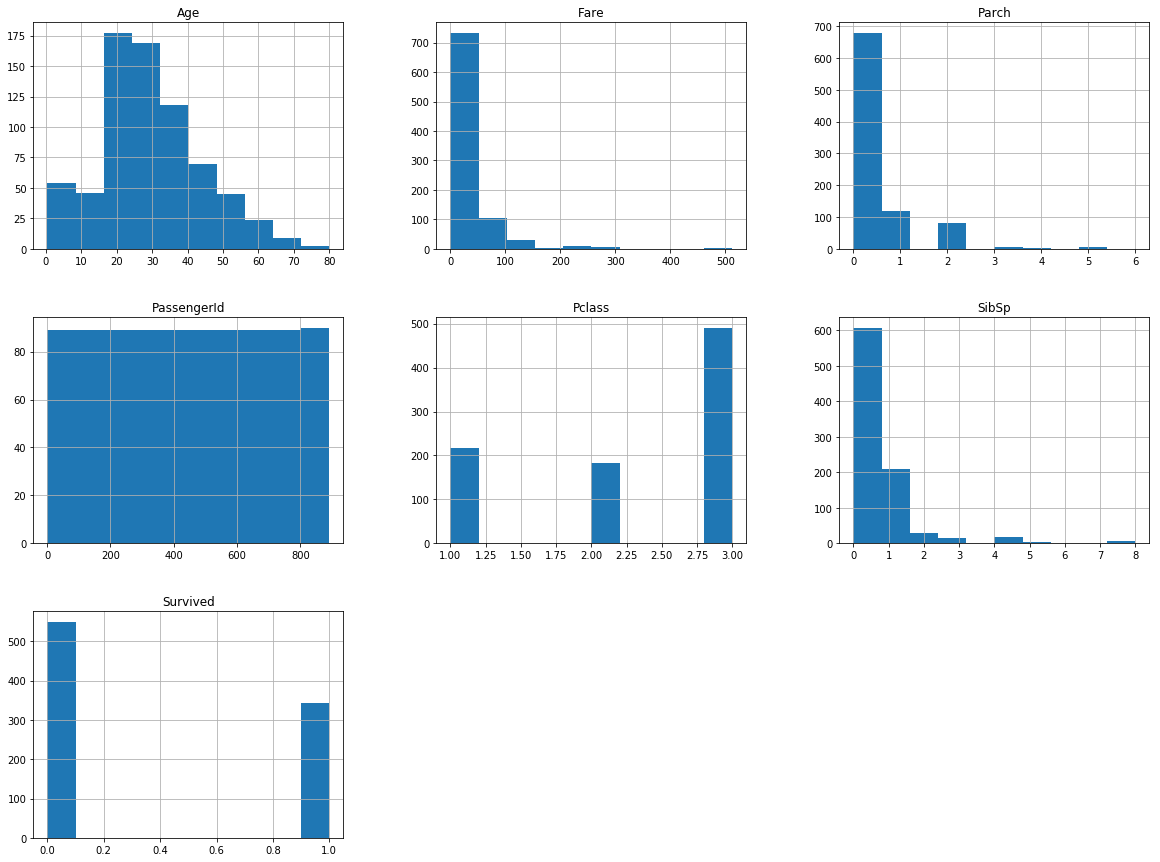

In [7]:
# Visualize numeric data
%matplotlib inline
import matplotlib.pyplot as plt
train_set.hist(bins=10, figsize=(20, 15))
plt.show()

In [8]:
# look for correlation of numerical features to survival
corr_matrix = train_set.corr()
corr_matrix['Survived'].sort_values(ascending=False)

Survived       1.000000
Fare           0.257307
Parch          0.081629
PassengerId   -0.005007
SibSp         -0.035322
Age           -0.077221
Pclass        -0.338481
Name: Survived, dtype: float64

In [9]:
# Prepare data for ML Algorithms
# update 'Sex' and 'Embarked' dtype to 'category'
titanic_tr = train_set.astype({'Sex': 'category', 'Embarked': 'category'})
titanic_tr.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null category
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null category
dtypes: category(2), float64(2), int64(5), object(3)
memory usage: 71.6+ KB


In [10]:
# Drop PassengerID, Name, Ticket, and Cabin features
titanic_tr = titanic_tr.drop(['PassengerId', 'Name', 'Ticket', 'Cabin'], axis=1)

In [11]:
# recode Sex
titanic_tr['Sex'] = titanic_tr['Sex'].cat.codes
titanic_tr.describe()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,0.383838,2.308642,0.647587,29.699118,0.523008,0.381594,32.204208
std,0.486592,0.836071,0.477990,14.526497,1.102743,0.806057,49.693429
min,0.000000,1.000000,0.000000,0.420000,0.000000,0.000000,0.000000
25%,0.000000,2.000000,0.000000,20.125000,0.000000,0.000000,7.910400
50%,0.000000,3.000000,1.000000,28.000000,0.000000,0.000000,14.454200
75%,1.000000,3.000000,1.000000,38.000000,1.000000,0.000000,31.000000
max,1.000000,3.000000,1.000000,80.000000,8.000000,6.000000,512.329200


In [12]:
# one hot encode Embark and then drop original
one_hot_encode = pd.get_dummies(titanic_tr['Embarked'], prefix='Embarked', dtype=int)
titanic_tr = titanic_tr.join(other=one_hot_encode)
titanic_tr = titanic_tr.drop('Embarked', axis=1)
titanic_tr.describe()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked_C,Embarked_Q,Embarked_S
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000
mean,0.383838,2.308642,0.647587,29.699118,0.523008,0.381594,32.204208,0.188552,0.086420,0.722783
std,0.486592,0.836071,0.477990,14.526497,1.102743,0.806057,49.693429,0.391372,0.281141,0.447876
min,0.000000,1.000000,0.000000,0.420000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,2.000000,0.000000,20.125000,0.000000,0.000000,7.910400,0.000000,0.000000,0.000000
50%,0.000000,3.000000,1.000000,28.000000,0.000000,0.000000,14.454200,0.000000,0.000000,1.000000
75%,1.000000,3.000000,1.000000,38.000000,1.000000,0.000000,31.000000,0.000000,0.000000,1.000000
max,1.000000,3.000000,1.000000,80.000000,8.000000,6.000000,512.329200,1.000000,1.000000,1.000000


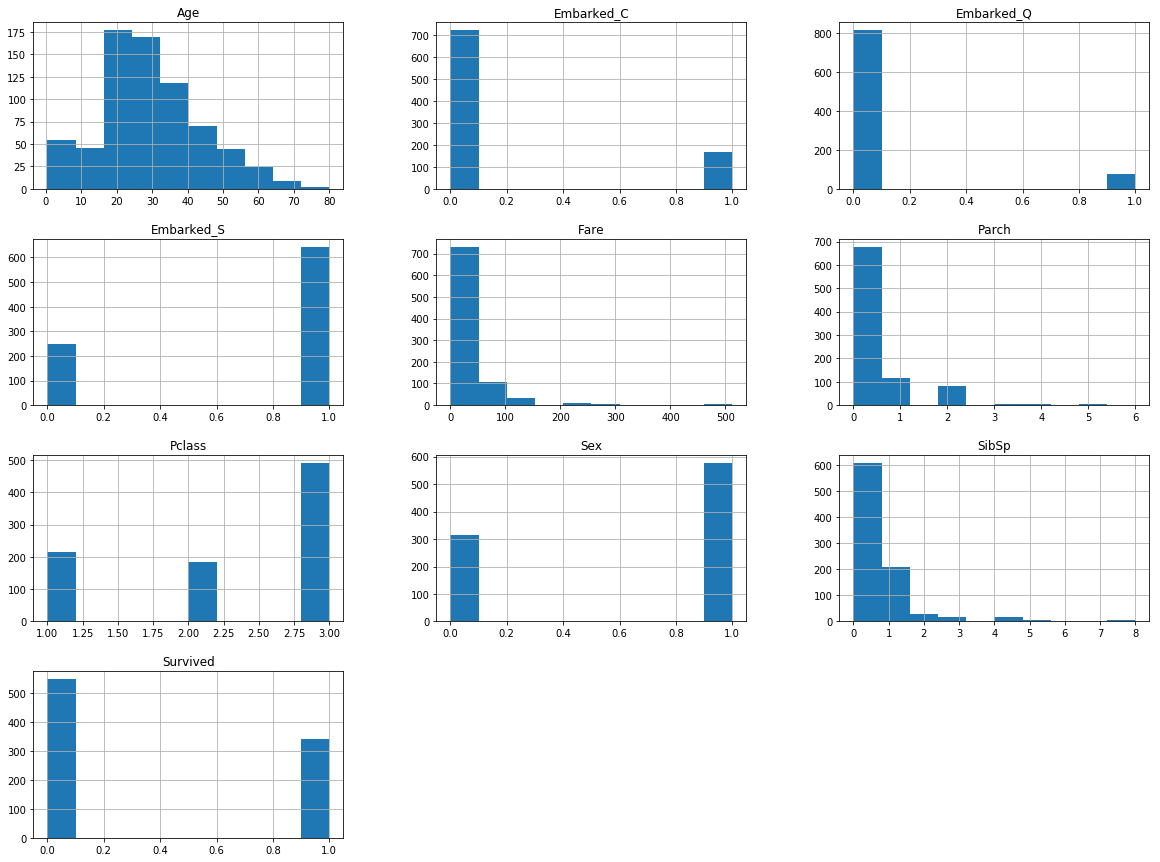

In [13]:
titanic_tr.hist(bins=10, figsize=(20, 15))
plt.show()

In [14]:
# Age has missing values - set the value to the median
titanic_tr['Age'] = titanic_tr['Age'].fillna(titanic_tr['Age'].median())
titanic_tr.describe()

# NOTE - should consider/attempt to predict missing age values as an alterntive to using median
# This on its own could be specific kernal to post on Kaggle - how the different methods populating missing
# data affects the predictive ability of the model.

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked_C,Embarked_Q,Embarked_S
count,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000
mean,0.383838,2.308642,0.647587,29.361582,0.523008,0.381594,32.204208,0.188552,0.086420,0.722783
std,0.486592,0.836071,0.477990,13.019697,1.102743,0.806057,49.693429,0.391372,0.281141,0.447876
min,0.000000,1.000000,0.000000,0.420000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,2.000000,0.000000,22.000000,0.000000,0.000000,7.910400,0.000000,0.000000,0.000000
50%,0.000000,3.000000,1.000000,28.000000,0.000000,0.000000,14.454200,0.000000,0.000000,1.000000
75%,1.000000,3.000000,1.000000,35.000000,1.000000,0.000000,31.000000,0.000000,0.000000,1.000000
max,1.000000,3.000000,1.000000,80.000000,8.000000,6.000000,512.329200,1.000000,1.000000,1.000000


In [15]:
# Feature scaling
# Pclass, Age, SibSp, Parch, and Fare need to be scaled to 0 - 1 range
# Note - will use standardization for scaling because of outlier effects

from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
titanic_scaled = pd.DataFrame(scaler.fit_transform(titanic_tr), columns=titanic_tr.columns)
titanic_scaled.describe()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked_C,Embarked_Q,Embarked_S
count,8.910000e+02,8.910000e+02,8.910000e+02,8.910000e+02,8.910000e+02,8.910000e+02,8.910000e+02,8.910000e+02,891.000000,8.910000e+02
mean,3.987333e-17,-8.772133e-17,-1.156327e-16,2.272780e-16,4.386066e-17,5.382900e-17,3.987333e-18,-1.993666e-17,0.000000,-4.984166e-17
std,1.000562e+00,1.000562e+00,1.000562e+00,1.000562e+00,1.000562e+00,1.000562e+00,1.000562e+00,1.000562e+00,1.000562,1.000562e+00
min,-7.892723e-01,-1.566107e+00,-1.355574e+00,-2.224156e+00,-4.745452e-01,-4.736736e-01,-6.484217e-01,-4.820427e-01,-0.307562,-1.614710e+00
25%,-7.892723e-01,-3.693648e-01,-1.355574e+00,-5.657365e-01,-4.745452e-01,-4.736736e-01,-4.891482e-01,-4.820427e-01,-0.307562,-1.614710e+00
50%,-7.892723e-01,8.273772e-01,7.376951e-01,-1.046374e-01,-4.745452e-01,-4.736736e-01,-3.573909e-01,-4.820427e-01,-0.307562,6.193064e-01
75%,1.266990e+00,8.273772e-01,7.376951e-01,4.333115e-01,4.327934e-01,-4.736736e-01,-2.424635e-02,-4.820427e-01,-0.307562,6.193064e-01
max,1.266990e+00,8.273772e-01,7.376951e-01,3.891554e+00,6.784163e+00,6.974147e+00,9.667167e+00,2.074505e+00,3.251373,6.193064e-01


In [18]:
# look for correlation of numerical features to survival
corr_matrix = titanic_scaled.corr()
corr_matrix['Survived'].sort_values(ascending=False)

Survived      1.000000
Fare          0.257307
Embarked_C    0.168240
Parch         0.081629
Embarked_Q    0.003650
SibSp        -0.035322
Age          -0.064910
Embarked_S   -0.155660
Pclass       -0.338481
Sex          -0.543351
Name: Survived, dtype: float64

In [19]:
# Embarked C and S, Fare, Pclass, and Sex seem to be good starting points for predicting survival.
# Sex, Pclass, and Fare being the top 3
titanic_scaled.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 10 columns):
Survived      891 non-null float64
Pclass        891 non-null float64
Sex           891 non-null float64
Age           891 non-null float64
SibSp         891 non-null float64
Parch         891 non-null float64
Fare          891 non-null float64
Embarked_C    891 non-null float64
Embarked_Q    891 non-null float64
Embarked_S    891 non-null float64
dtypes: float64(10)
memory usage: 69.7 KB


In [20]:
# drop survived from training sample because its the target
titanic_scaled = titanic_scaled.drop('Survived', axis=1)
target = titanic_tr['Survived']

from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(titanic_scaled, target)

/Users/KweningJ/Documents/ML-Workspace/env/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


SGDClassifier(alpha=0.0001, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='hinge', max_iter=None, n_iter=None,
       n_jobs=1, penalty='l2', power_t=0.5, random_state=42, shuffle=True,
       tol=None, verbose=0, warm_start=False)

In [30]:
# Validate general SGD model with cross-validation

def display_scores(scores):
    print('Scores:', scores)
    print('Mean:', scores.mean())
    print('Standard deviation:', scores.std())

from sklearn.model_selection import cross_val_score

scores = cross_val_score(sgd_clf, titanic_scaled, target, cv=20)
display_scores(scores)

Scores: [0.76086957 0.76086957 0.68888889 0.66666667 0.6        0.62222222
 0.71111111 0.77777778 0.66666667 0.77272727 0.72727273 0.65909091
 0.72727273 0.77272727 0.72727273 0.75       0.81818182 0.68181818
 0.59090909 0.84090909]
Mean: 0.7161627140974968
Standard deviation: 0.06700396731417203


/Users/KweningJ/Documents/ML-Workspace/env/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
/Users/KweningJ/Documents/ML-Workspace/env/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % typ

In [32]:
# Validat with confusion matrix for general SGD

# get predictions from cross validation
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix

titanic_pred = cross_val_predict(sgd_clf, titanic_scaled, target, cv=20)
confusion_matrix(target, titanic_pred)

/Users/KweningJ/Documents/ML-Workspace/env/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
/Users/KweningJ/Documents/ML-Workspace/env/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % typ

array([[451,  98],
       [155, 187]])

In [34]:
# Precision and Recall scores
from sklearn.metrics import precision_score, recall_score, f1_score

print('precision score:', precision_score(target, titanic_pred))
print('recall score:', recall_score(target, titanic_pred))
print('f1 score:', f1_score(target, titanic_pred))

# Note - which to favor or want similar precision/recal scors -> F1 scores ~ 1
# For this purpose, I believe we want to maximize the F1 score

precision score: 0.656140350877193
recall score: 0.5467836257309941
f1 score: 0.5964912280701754


In [ ]:
# Plot precision recall curv
from sklearn.metrics import precision_recall_curve

prob
precisions, recalls, thresholds = precision_recall_curve()